Thinkful Bootcamp Course

Author: Ian Heaton

Email: iheaton@gmail.com

Mentor: Nemanja Radojkovic

Date: 2017/06/13


In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import spacy
import re

from nltk.corpus import gutenberg, stopwords
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble
from sklearn import metrics
from collections import Counter

%matplotlib inline

sb.set_style('darkgrid')
my_dpi = 96

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Classification of Lewis Carroll and Jane Austen works using Natural Language Processing 


## Question:
How well can term frequency of two documents be used in the classification of these texts? Can term frequency-inverse document frequency produce better accuracy scores when used to classify three different texts?

### Data:
The three texts to be sued in the classification are
1.	Alice's Adventures in Wonderland by Lewis Carrol
2.	Persuasion by Jane Austen
3.	Moby Dick by Herman Melville



In [2]:
# Utility function for standard text cleaning.
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'.  Better get rid of it now!
    text = re.sub(r'--',' ',text)
    text = re.sub("[\[].*?[\]]", "", text)
    text = ' '.join(text.split())
    return text
    
# Load and clean the data.
persuasion = gutenberg.raw('austen-persuasion.txt')
alice = gutenberg.raw('carroll-alice.txt')

# The Chapter indicator is idiosyncratic
persuasion = re.sub(r'Chapter \d+', '', persuasion)
alice = re.sub(r'CHAPTER .*', '', alice)
    
alice = text_cleaner(alice)
persuasion = text_cleaner(persuasion)

### Preprocessing and exploratory data analysis

Load the two novels of interest Alice in Wonderland and Jane Austens Persuasion.

In [3]:
# Parse the cleaned novels. This can take a bit.
nlp = spacy.load('en')
alice_doc = nlp(alice)
persuasion_doc = nlp(persuasion)

In [4]:
# Group into sentences.
alice_sents = [[sent, "Carroll"] for sent in alice_doc.sents]
persuasion_sents = [[sent, "Austen"] for sent in persuasion_doc.sents]

# Combine the sentences from the two novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents)
sentences.columns = ['sentence', 'author']
print('\n%s \n' % sentences.author.value_counts())
sentences.head()


Austen     3361
Carroll    1179
Name: author, dtype: int64 



,sentence,author
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !, I, shall, be, late, !, ')",Carroll
4,"((, when, she, thought, it, over, afterwards, ...",Carroll


We next collect all the words from both texts that are not stop words, punctuation and find the root words.  For the resulting set of words the part of speech are collected and the percentage os computed each part of speech for both texts. The results are plotted in a bar graph to determine how different the part of speech usage between the texts is.

In [36]:
# Creates a data frame with features for each word in our common word set.
# Each value is the count of the times the word appears in each sentence.
def bow_features(sentences, common_words):
    
    # Scaffold the data frame and initialize counts to zero.
    df = pd.DataFrame(columns=common_words)
    df['text_sentence'] = sentences.sentence
    df['text_source'] = sentences.author
    df.loc[:, common_words] = 0
    
    # Process each row, counting the occurrence of words in each sentence.
    for i, sentence in enumerate(df['text_sentence']):
        
        # Convert the sentence to lemmas, then filter out punctuation,
        # stop words, and uncommon words.
        words = [token.lemma_
                 for token in sentence
                 if (
                     not token.is_punct
                     and not token.is_stop
                     and token.lemma_ in common_words
                 )]
        
        # Populate the row with word counts.
        for word in words:
            df.loc[i, word] += 1
        
        # This counter is just to make sure the kernel didn't hang.
        if i % 500 == 0:
            print("Processing row {}".format(i))
            
    return df


def normalize_text(text, most_common=None):
    
    # Filter out punctuation and stop words.
    allwords = [token.lemma_ for token in text if not token.is_punct and not token.is_stop]
    
    # Return the most common words.
    if most_common:
        return [item[0] for item in Counter(allwords).most_common(most_common)]
    else:
        return allwords

    
def tfidf_transformer(bow_matrix):
    
    transformer = TfidfTransformer(norm='l2',
                                   smooth_idf=True,
                                   use_idf=True)
    tfidf_matrix = transformer.fit_transform(bow_matrix)
    return transformer, tfidf_matrix
    
    
def tfidf_extractor(corpus, ngram_range=(1,1)):
    
    vectorizer = TfidfVectorizer(min_df=1, 
                                 smooth_idf=True,
                                 use_idf=True,
                                 norm='l2',
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


def create_tfidf_features(words):

    print('Number of words before vectorizer %d' % len(words))
    tfidf_vect, tdidf_features = tfidf_extractor(words)
    features = np.round(tdidf_features.todense(), 2)
    #features = tdidf_features.todense()
    word_matrix = pd.DataFrame(features, columns=tfidf_vect.get_feature_names())
    
    print('\n --- The number of observations after vectorizer : %d\n' % (word_matrix.shape[0]))
    return word_matrix, features
    
    
def sentence_vectorizer(sentence):
    sent_vec = np.zeros(400)
    numw = 0
    for w in sentence:
        try:
            # assumes spaCy word vectors
            sent_vec = np.add(sent_vec, w.vector)
            numw+=1
        except:
            pass
    return sent_vec / np.sqrt(sent_vec.dot(sent_vec))


def build_avg_sentence_vector_feature(sentences):
    feature_vector = np.zeros((500,),dtype="float64")
    for sent in enumerate(sentences['sentence']):
        feature_vector = np.append(feature_vector, sentence_vectorizer(sent))
        
    return feature_vector
    

Since spaCy has already tokenized and labelled our data, we can move directly to recording how often various words occur. We will exclude stopwords and punctuation. In addition, in an attempt to keep our feature space from exploding, we will work with lemmas (root words) rather than the raw text terms, and we'll only use the 3000 most common words for each text.

As an improvement to the bag of words model used in the original version of this notebook is a Term Frequency-Inverse Document Frequency model will be used.  The bag of words model is based on the absolute frequences of word usage. Those words that tend to be used through the texts will overshadow those words that are not used as often. These other words may be more interesting if they can help determine the writing style of an author. If this can be done our model will be likely to have higher accuracy for classifying books that it has not seen before.

An advantage to using TF-IDF is that  the inverse document frequency factor will reduce the weight of words that occur very frequently in the document set such the word ‘the’ and increases the weight of terms that occur rarely.  Together TF-IDF tend to reduce common words. 

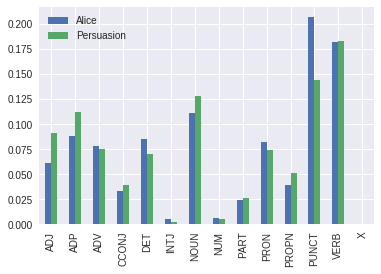

In [6]:
alicewords = normalize_text(alice_doc)
persuasionwords = normalize_text(persuasion_doc)
# Make a quick-and-dirty lookup table of POS IDs, 
# since the default representation of a POS is numeric. 
tagDict = {w.pos: w.pos_ for w in alice_doc} 

alicePOS = pd.Series(alice_doc.count_by(spacy.attrs.POS))/len(alice_doc)
persuasionPOS = pd.Series(persuasion_doc.count_by(spacy.attrs.POS))/len(persuasion_doc)

df = pd.DataFrame([alicePOS, persuasionPOS], index=['Alice', 'Persuasion'])
df.columns = [tagDict[column] for column in df.columns]
__ = plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = df.T.plot(kind='bar')

In [118]:
# we will use the 5000 most common words
alicewords = normalize_text(alice_doc, most_common=5000)
persuasionwords = normalize_text(persuasion_doc, most_common=5000)
common_words = set(alicewords + persuasionwords)

# the following function will return a data frame and a numpy matrix
bow_df = bow_features(sentences, common_words)
df = bow_df.drop(['text_sentence','text_source'], axis=1)
df = df.convert_objects(convert_numeric=True)

X = np.array(df)

__, X =  tfidf_transformer(X)


print(sentences.shape)
print('\nNumber of Sentences is : %d' % X.shape[0])
print('\nNumber of Words is : %d' % X.shape[1])

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


(4540, 2)

Number of Sentences is : 4540

Number of Words is : 4938


In [119]:
sentDict = {}

for i, sentence in enumerate(sentences['sentence']):
    posDict = {w.pos_: 0 for w in alice_doc} 
    for word in sentence:
        posDict[word.pos_] = posDict.get(word.pos_) + 1
    sentDict[i] = posDict
        
df = pd.DataFrame(sentDict).T
print(df.shape)

X = np.append(X.toarray(), df.values, 1)
#X = np.append(X, df.values, 1)
print(X.shape)
df.head()

(4540, 14)
(4540, 4952)


,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,VERB,X
0,3,8,3,6,5,0,12,0,3,3,2,9,13,0
1,7,8,7,2,6,0,8,0,1,4,2,7,11,0
2,2,6,1,1,3,2,2,0,1,2,4,4,5,0
3,1,0,0,0,0,2,0,0,0,1,0,3,2,0
4,5,18,11,8,11,0,15,0,5,13,4,17,19,0


In [20]:
# Timing context manager for statement invocations.
# Taken from Python Cookbook section 14.13
import time

from contextlib import contextmanager
@contextmanager
def timeblock(label):
    start = time.perf_counter()
    try:
        yield
    finally:
        end = time.perf_counter()
        print('{} : {:.2f} secs'.format(label, end - start))

## Model Building

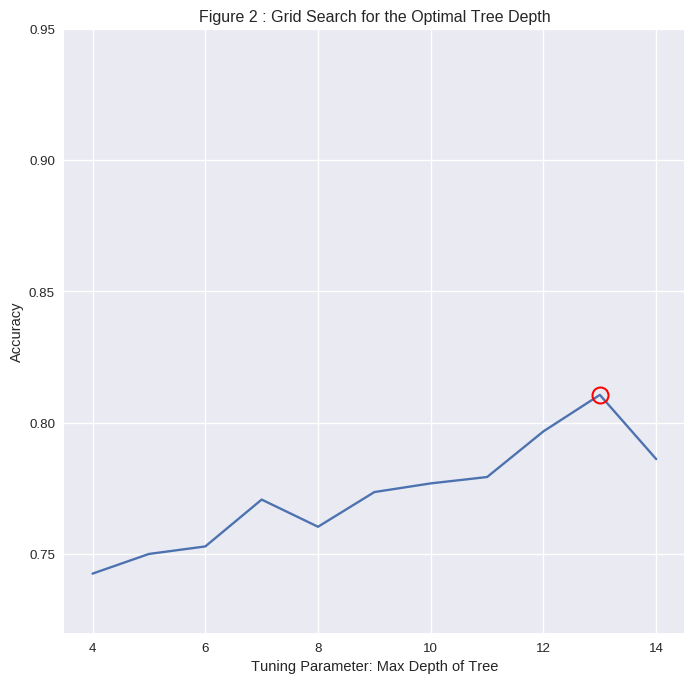

In [120]:
# Let us find the best value for depth of tree
rfc = ensemble.RandomForestClassifier()
y = np.where(sentences.author == 'Carroll', 0, 1)

max_depth_range = list(range(4, 15))
param_grid = dict(max_depth=max_depth_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X, y)

# check the results of the grid search
#print(grid.grid_scores_)
grid.grid_scores_[1]
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.72, .95])
plt.xlabel('Tuning Parameter: Max Depth of Tree')
plt.ylabel('Accuracy')
plt.plot(max_depth_range, grid_mean_scores)
plt.title('Figure 2 : Grid Search for the Optimal Tree Depth')
__ = plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

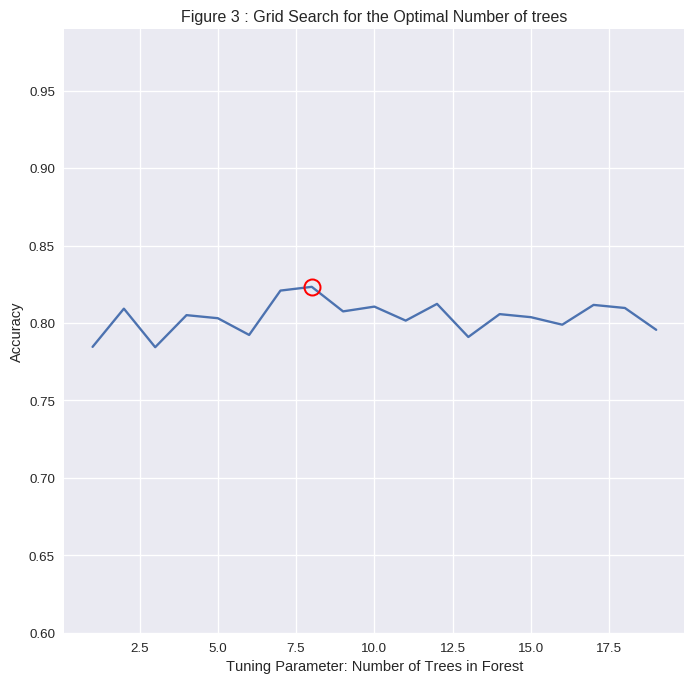

In [121]:
# Let us find the best value for the number of trees in the forest
rfc = ensemble.RandomForestClassifier(max_depth=14)

max_trees_range = list(range(1, 20))
param_grid = dict(n_estimators=max_trees_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X, y)


# check the results of the grid search
#print(grid.grid_scores_)
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.60, 0.99])
plt.xlabel('Tuning Parameter: Number of Trees in Forest')
plt.ylabel('Accuracy')
plt.plot(max_trees_range, grid_mean_scores)
plt.title('Figure 3 : Grid Search for the Optimal Number of trees')
__ = plt.plot(grid.best_params_['n_estimators'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

(4540,)

 {0: 1179, 1: 3361} 

Time Spent computing cross validation scores : 2.86 secs


[ 0.90821256  0.90891473  0.9178744   0.94070352  0.9270217   0.88345865
  0.92371134]
Accuracy: 0.92 (+/- 0.03)


Time Spent training Random Forest : 0.24 secs
[0 1]
             precision    recall  f1-score   support

    Carroll       0.88      0.60      0.72       483
     Austen       0.87      0.97      0.92      1333

avg / total       0.87      0.87      0.86      1816





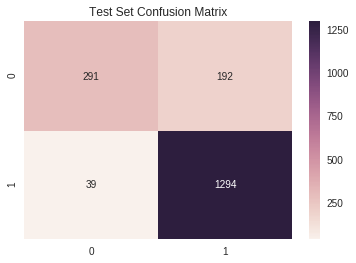

In [125]:
from sklearn import ensemble

print(y.shape)
unique, counts = np.unique(y, return_counts=True)
print('\n %s \n' % (dict(zip(unique, counts))))

# Austen     3361
# Carroll    1179

rfc = ensemble.RandomForestClassifier(max_depth=13, n_estimators=8, class_weight={0:.7, 1:.3})

with timeblock('Time Spent computing cross validation scores'):
    scores = cross_val_score(rfc, X, y, cv=7, scoring='f1')

print('\n')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n\n" % (scores.mean(), scores.std() * 2))

# Done to retieve the Precision, Recall and the Confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

with timeblock('Time Spent training Random Forest'):
    rfc.fit(X_train, y_train)
    
y_ = rfc.predict(X_test)

print(rfc.classes_)
target_names = ['Carroll', 'Austen']
print(classification_report(y_test, y_, target_names=target_names))
print('\n')
cnfsn_mtrx = metrics.confusion_matrix(y_test, y_)

# Display heatmap of confusion matrix
__ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
__ = plt.title("Test Set Confusion Matrix")

### Preprocessing and exploratory data analysis II

Read in Melville’ s Moby Dick and clean text and initialize a spaCy instance.

In [151]:
# Great American Classic
moby_dick_doc = gutenberg.raw('melville-moby_dick.txt')

# Start reading doc past the ETYMOLOGY section and first chapter heading
moby_dick = moby_dick_doc[21958:]

# The Chapter indicator is idiosyncratic
#persuasion = re.sub(r'Chapter \d+', '', persuasion)
moby_dick = re.sub(r'CHAPTER .*', '', moby_dick)
    
moby_dick = text_cleaner(moby_dick)
moby_dick_doc = nlp(moby_dick)

Parse document for sentences and create a new Data frame containing the spaCy token objects from Alice in Wonderland and Persuasion. 

In [153]:
moby_dick_sents = [[sent, "Melville"] for sent in moby_dick_doc.sents]

# Combine the sentences from the three novels into one data frame.
sentences = pd.DataFrame(alice_sents + persuasion_sents + moby_dick_sents)
sentences.columns = ['sentence', 'author']
print('\n%s \n' % sentences.author.value_counts())
sentences.head()


Melville    8572
Austen      3361
Carroll     1179
Name: author, dtype: int64 



,sentence,author
0,"(Alice, was, beginning, to, get, very, tired, ...",Carroll
1,"(So, she, was, considering, in, her, own, mind...",Carroll
2,"(There, was, nothing, so, VERY, remarkable, in...",Carroll
3,"(Oh, dear, !, I, shall, be, late, !, ')",Carroll
4,"((, when, she, thought, it, over, afterwards, ...",Carroll


Next, we compute the distribution of parts of speech in each text. This might provide more of a rationale for use in the classification step. 

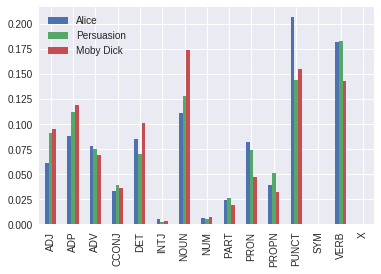

In [156]:
moby_dickwords = normalize_text(moby_dick_doc)

# need a new part of speech dictionary
tagDict = {w.pos: w.pos_ for w in moby_dick_doc} 
mobydickPOS = pd.Series(moby_dick_doc.count_by(spacy.attrs.POS))/len(moby_dick_doc)

df = pd.DataFrame([alicePOS, persuasionPOS, mobydickPOS], index=['Alice', 'Persuasion', 'Moby Dick'])
df.columns = [tagDict[column] for column in df.columns]
__ = plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
__ = df.T.plot(kind='bar')

In [179]:
# we will use the 5000 most common words
alicewords = normalize_text(alice_doc, most_common=5000)
persuasionwords = normalize_text(persuasion_doc, most_common=5000)
mobydickwords = normalize_text(moby_dick_doc, most_common=5000)

common_words = set(alicewords + persuasionwords + mobydickwords)

# the following function will return a data frame and a numpy matrix
bow_df = bow_features(sentences, common_words)
df = bow_df.drop(['text_sentence','text_source'], axis=1)
df = df.convert_objects(convert_numeric=True)

X = np.array(df)

# Create td-idf sparse matrix from bag of words
__, X =  tfidf_transformer(X)

Processing row 0
Processing row 500
Processing row 1000
Processing row 1500
Processing row 2000
Processing row 2500
Processing row 3000
Processing row 3500
Processing row 4000
Processing row 4500
Processing row 5000
Processing row 5500
Processing row 6000
Processing row 6500
Processing row 7000
Processing row 7500
Processing row 8000
Processing row 8500
Processing row 9000
Processing row 9500
Processing row 10000
Processing row 10500
Processing row 11000
Processing row 11500
Processing row 12000
Processing row 12500
Processing row 13000


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


We build another matrix composed of all the parts of speech of all the sentences form the three novels. The resulting array is appended to the TF-IDF array.

In [180]:
print('\nNumber of Sentences is : %d' % X.shape[0])
print('\nNumber of Words is : %d' % X.shape[1])

# Now calculate the number of the part of speech for each sentence
sentDict = {}

for i, sentence in enumerate(sentences['sentence']):
    posDict = {w.pos_: 0 for w in moby_dick_doc} 
    for word in sentence:
        posDict[word.pos_] = posDict.get(word.pos_) + 1
    sentDict[i] = posDict
        
df = pd.DataFrame(sentDict).T
print(df.shape)

X = np.append(X.toarray(), df.values, 1)
#X = np.append(X, df.values, 1)
print(X.shape)
df.head()


Number of Sentences is : 13112

Number of Words is : 7495
(13112, 15)
(13112, 7510)


,ADJ,ADP,ADV,CCONJ,DET,INTJ,NOUN,NUM,PART,PRON,PROPN,PUNCT,SYM,VERB,X
0,3,8,3,6,5,0,12,0,3,3,2,9,0,13,0
1,7,8,7,2,6,0,8,0,1,4,2,7,0,11,0
2,2,6,1,1,3,2,2,0,1,2,4,4,0,5,0
3,1,0,0,0,0,2,0,0,0,1,0,3,0,2,0
4,5,18,11,8,11,0,15,0,5,13,4,17,0,19,0


In [181]:
# Author names to integers

author_mapping = {'Carroll':1, 'Austen':2, 'Melville':3}

sentences['label'] = sentences.author.map(author_mapping)
sentences.label.value_counts()


3    8572
2    3361
1    1179
Name: label, dtype: int64

## Model Building II

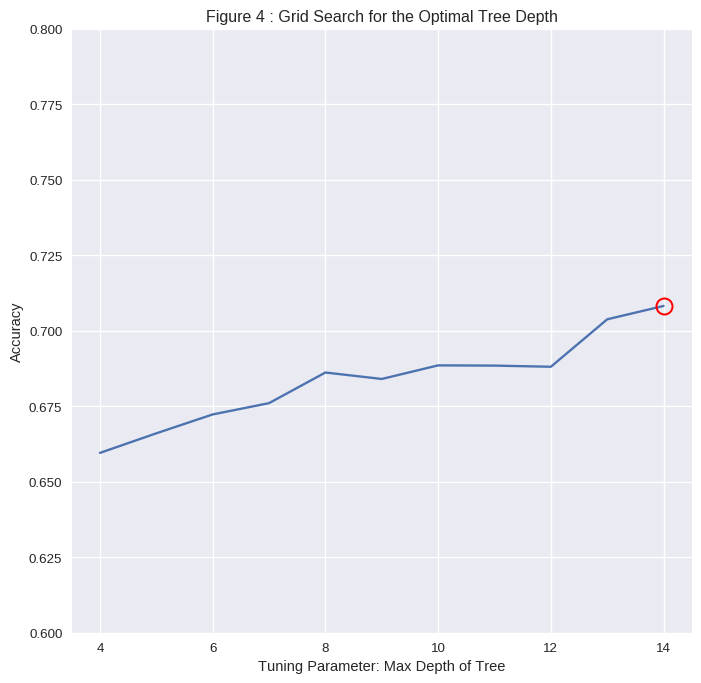

In [182]:
# Let us find the best value for depth of tree
rfc = ensemble.RandomForestClassifier()
y = sentences.label

max_depth_range = list(range(4, 15))
param_grid = dict(max_depth=max_depth_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X, y)

# check the results of the grid search
#print(grid.grid_scores_)
grid.grid_scores_[1]
grid_mean_scores = [result[1] for result in grid.grid_scores_]
# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.60, .80])
plt.xlabel('Tuning Parameter: Max Depth of Tree')
plt.ylabel('Accuracy')
plt.plot(max_depth_range, grid_mean_scores)
plt.title('Figure 4 : Grid Search for the Optimal Tree Depth')
__ = plt.plot(grid.best_params_['max_depth'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')

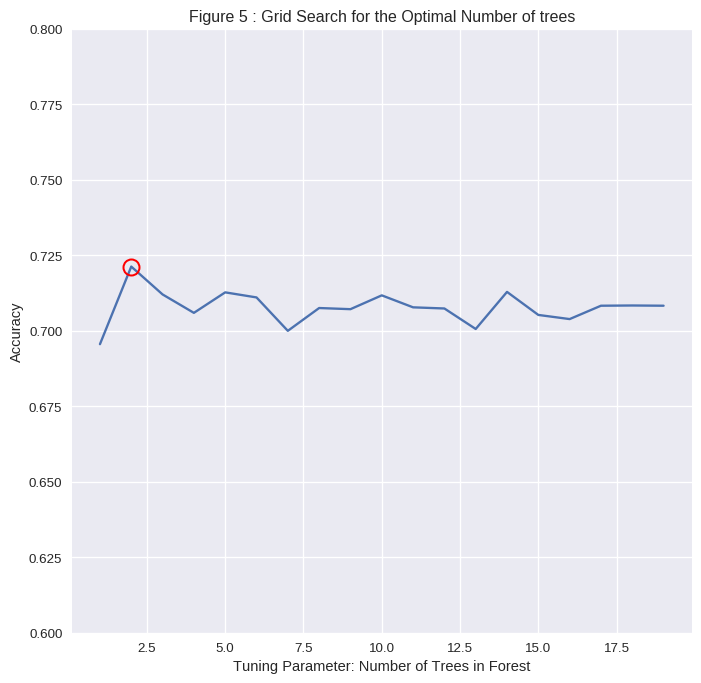

In [183]:
# Let us find the best value for the number of trees in the forest
rfc = ensemble.RandomForestClassifier(max_depth=14)

max_trees_range = list(range(1, 20))
param_grid = dict(n_estimators=max_trees_range)

grid = GridSearchCV(rfc, param_grid, cv=5)
grid.fit(X, y)


# check the results of the grid search
#print(grid.grid_scores_)
grid_mean_scores = [result[1] for result in grid.grid_scores_]

# this is a list of the average accuracies for each parameter combination
plt.figure(figsize=(800/my_dpi, 800/my_dpi), dpi=my_dpi)
plt.ylim([0.60, 0.80])
plt.xlabel('Tuning Parameter: Number of Trees in Forest')
plt.ylabel('Accuracy')
plt.plot(max_trees_range, grid_mean_scores)
plt.title('Figure 5 : Grid Search for the Optimal Number of trees')
__ = plt.plot(grid.best_params_['n_estimators'], grid.best_score_, 'ro', markersize=12, markeredgewidth=1.5,
         markerfacecolor='None', markeredgecolor='r')


 {1: 1179, 2: 3361, 3: 8572} 

Time Spent computing cross validation scores : 5.36 secs


[ 0.6992      0.72091782  0.76627535  0.76775227  0.72863248  0.75534188
  0.71207265]
Accuracy: 0.74 (+/- 0.05)


Time Spent training Random Forest : 0.59 secs
[1 2 3]
             precision    recall  f1-score   support

    Carroll       0.68      0.08      0.14       462
     Austen       0.87      0.23      0.37      1307
   Melville       0.71      0.99      0.83      3476

avg / total       0.75      0.72      0.65      5245





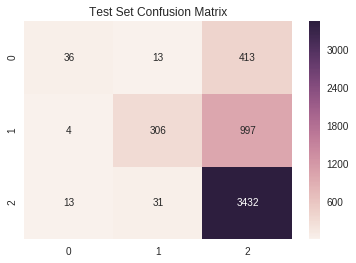

In [184]:
unique, counts = np.unique(y, return_counts=True)
print('\n %s \n' % (dict(zip(unique, counts))))

rfc = ensemble.RandomForestClassifier(max_depth=14, n_estimators=2, class_weight={1:.6, 2:.3, 3:1})

with timeblock('Time Spent computing cross validation scores'):
    scores = cross_val_score(rfc, X, y, cv=7, scoring='f1_micro')

print('\n')
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)\n\n" % (scores.mean(), scores.std() * 2))

# Done to retieve the Precision, Recall and the Confusion matrix
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

with timeblock('Time Spent training Random Forest'):
    rfc.fit(X_train, y_train)
    
y_ = rfc.predict(X_test)

print(rfc.classes_)
target_names = ['Carroll', 'Austen', 'Melville']
print(classification_report(y_test, y_, target_names=target_names))
print('\n')
cnfsn_mtrx = metrics.confusion_matrix(y_test, y_)

# Display heatmap of confusion matrix
__ = sb.heatmap(cnfsn_mtrx, annot=True, fmt="d")
__ = plt.title("Test Set Confusion Matrix")

## Discussion

For the first classification step, determining if a sentence was written by Jane Austen or Lewis Carroll resulted in a mean cross validation score of 0.92.  This was obtained by converting a bag of words to a term frequency-inverse document frequency (TF-IDF) encoding. The number of predictions made that are actually correct for both classes was 0.88 and 0.87 while the number of instances of each class that was correctly predicted is 0.60 and 0.92.  The number of sentences is quite unbalanced, with Alice I wonderland comprising only 26 % of the sentences. I was unable to obtain an accuracy over 97 using the TF-IDF and including the number of the part of speech of each sentence in the model.

The second classification step used an additional work by Herman Melville.   TF-IDF was superior than bag of words.  The number of sentence for each author was unbalances with those written by Melville comprising 65 % of the total.  The mean cross validation accuracy was 0.74.  The number of predictions made that are actually correct for both classes was 0.68, 0.87 and 0.71 while the number of instances of each class that was correctly predicted was 0.08, 0.23 and 0.99. The model did a rather poor job of predicted those sentences written by Lewis Carrol.